In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import load_model, Model
import keras.backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, SpatialDropout2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import time
import cv2
import sys
from imutils import paths
import imutils
from matplotlib import pyplot as plt
%matplotlib inline
from keras.utils import np_utils

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# Load cifar10 dataset
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [0]:
# Normalize the dataset
from keras.utils import np_utils
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
n_classes = 10

In [26]:
# base model reference
!pip install image-classifiers
!pip install git+https://github.com/qubvel/classification_models.git

     |████████████████████████████████| 81kB 3.0MB/s 
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-95940uob
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-95940uob
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-ltcil0wn/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [10]:
#load model resnet18 trained for imagenet
from keras.layers import Reshape, Activation, Conv2D
from classification_models.resnet import ResNet18, preprocess_input

base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top=False)
x = Conv2D(10, (1,1), strides=(1,1), padding='same', name='conv_1', use_bias=False)(base_model.output)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax')(x)

model = Model(inputs=[base_model.input], outputs=[output])

W0714 11:24:55.260189 140638565259136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 11:24:55.312711 140638565259136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 11:24:55.314090 140638565259136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0714 11:24:55.315315 140638565259136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0714 11:24:55.317311 140638

44924928/44920640 [==============================] - 4s 0us/step


In [0]:
# Add Cut off
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
# checkpoint
filepath = '/content/drive/My Drive/Colab Notebooks/EIP3_phase2/assignment5phase2a/'
filepath = filepath + "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [LearningRateScheduler(scheduler, verbose=1), checkpoint]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., shuffle=True, callbacks=[<keras.ca..., verbose=0, steps_per_epoch=97, epochs=20)`
  
W0714 06:58:09.297866 140171078514560 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be 


Epoch 00001: LearningRateScheduler setting learning rate to 0.003.

Epoch 00001: val_acc improved from -inf to 0.63050, saving model to /content/drive/My Drive/Colab Notebooks/EIP3_phase2/assignment5phase2a/weights-improvement-01-0.63.hdf5

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.

Epoch 00002: val_acc improved from 0.63050 to 0.70260, saving model to /content/drive/My Drive/Colab Notebooks/EIP3_phase2/assignment5phase2a/weights-improvement-02-0.70.hdf5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.

Epoch 00003: val_acc improved from 0.70260 to 0.77010, saving model to /content/drive/My Drive/Colab Notebooks/EIP3_phase2/assignment5phase2a/weights-improvement-03-0.77.hdf5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.

Epoch 00004: val_acc improved from 0.77010 to 0.80110, saving model to /content/drive/My Drive/Colab Notebooks/EIP3_phase2/assignment5phase2a/weights-improvement-04-0.80.hdf5

Epoch

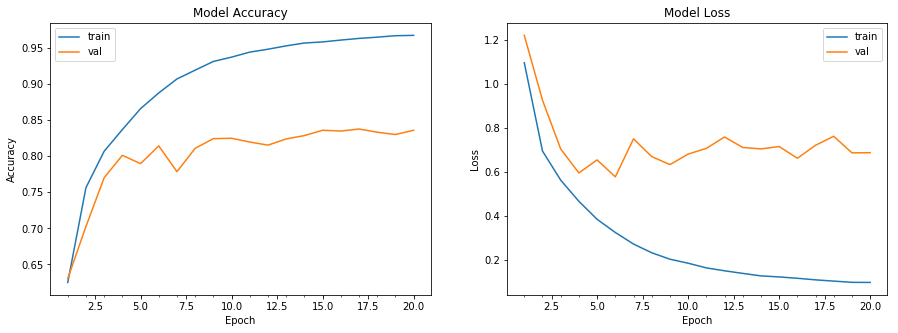

Accuracy on test data is: 83.58


In [14]:
# batch_size 512 and 128 best suits on observations
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1),
                              zoom_range=0.0, 
                              horizontal_flip=False)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 512),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 20, 
                                 validation_data = (test_features, test_labels), shuffle=False, callbacks=callbacks_list,
                                 verbose=0)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [34]:
# load the network
model.load_weights('/content/drive/My Drive/Colab Notebooks/EIP3_phase2/assignment5phase2a/weights-improvement-17-0.84.hdf5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)
validation_data = datagen.flow(test_features, test_labels,batch_size=128,shuffle=False)

In [0]:
Y_pred = model.predict_generator(validation_data, steps=np.ceil(test_features.shape[0]/128), verbose=0)
y_pred = np.argmax(Y_pred, axis=1)

In [15]:
import pandas as pd
d = {'pred': np.argmax(Y_pred,axis=1), 'true': np.argmax(test_labels,axis=1)} #axis=1!important!
df = pd.DataFrame(data=d)

# shows total mistakes
df2 = df[(df.pred != df.true)]
df2

df2.shape

(1625, 2)

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

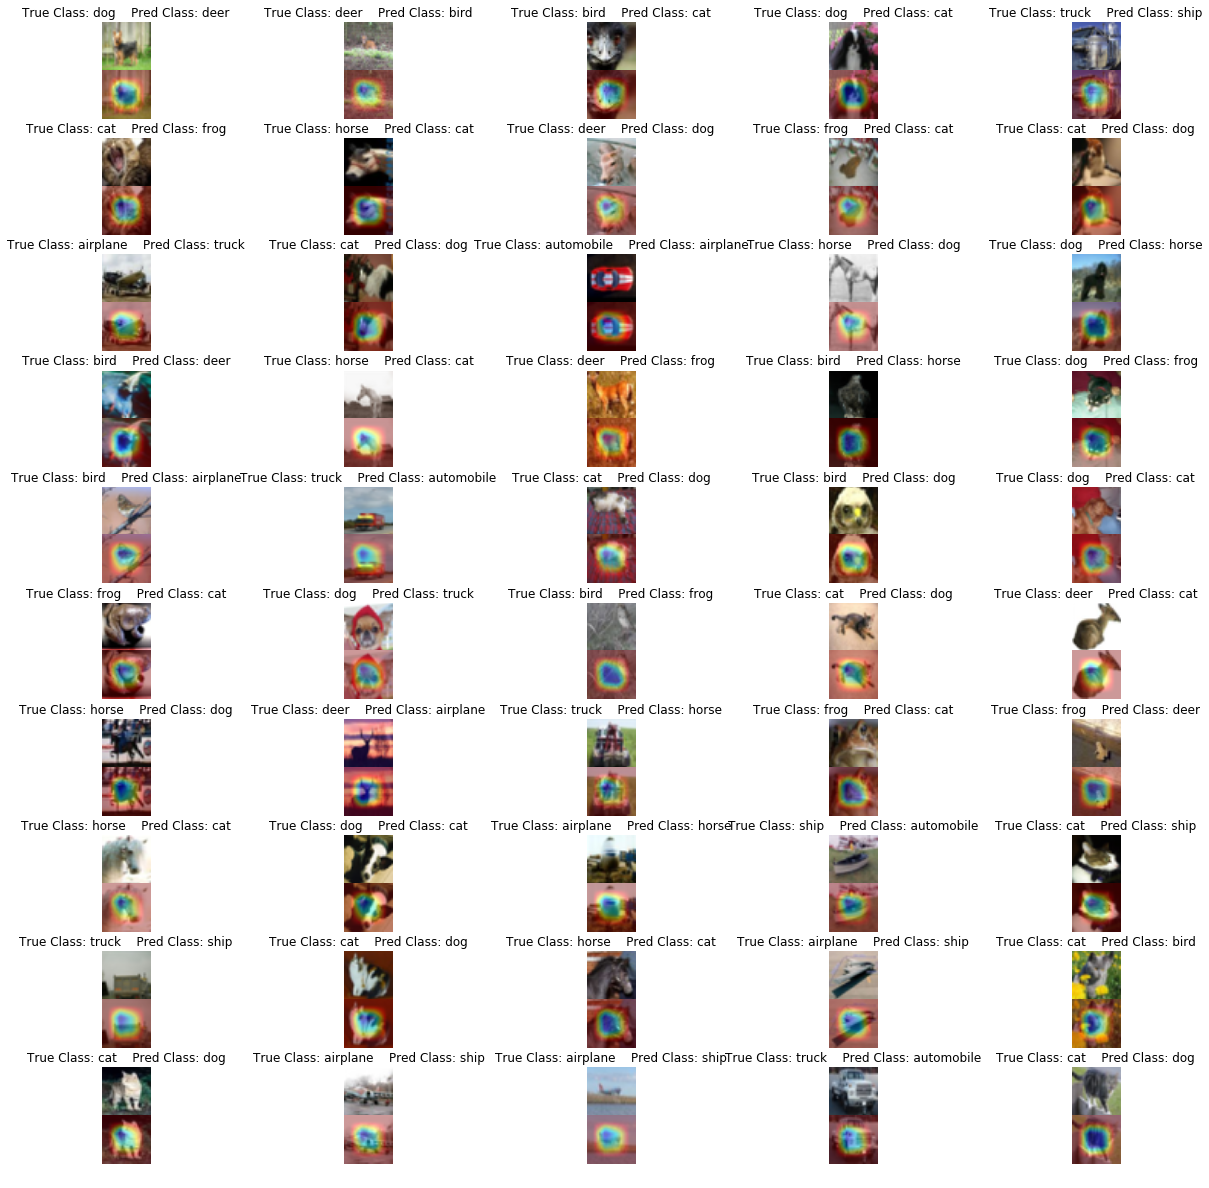

In [58]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
import keras.backend as K
import numpy as np
import cv2
import sys

plt.figure(figsize = (21,21))

for i in range(50):
    plt.subplot(10,5,i+1)
    #ax1, ax2 = axes
    #plt.imshow(test_features[df2.index[i]])
    img = test_features[df2.index[i]]
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("zero_padding2d_15")
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for j in range(256):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[j]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    img= cv2.resize(img,(224,224))
    superimposed_img= cv2.resize(superimposed_img,(224,224))
    final = np.concatenate((img, superimposed_img), axis = 0)
    
    plt.imshow(final)
    
    plt.title("True Class: " + str(class_names[df2["true"].iloc[i]])+"    Pred Class: " + str(class_names[df2["pred"].iloc[i]]))
    plt.axis('off')
    
plt.show()